# WSDM-EDA Basing on Songs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import check_output
%matplotlib inline

In [2]:
print(check_output(["ls", "/home/huangcr/Kaggle/wsdm/data"]).decode("utf8"))

members.csv
mytrain.csv
mytrain_sample.csv
myvalid.csv
sample_submission.csv
song_extra_info.csv
songs.csv
submission_lgbm_avg.csv.gz
test.csv
train.csv



In [3]:
train = pd.read_csv('../data/train.csv')
songs = pd.read_csv('../data/songs.csv')
test = pd.read_csv('../data/test.csv')

## 训练集 测试集 分析


In [4]:
print(train.columns)
songs.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target'],
      dtype='object')


Index(['song_id', 'song_length', 'genre_ids', 'artist_name', 'composer',
       'lyricist', 'language'],
      dtype='object')

In [5]:
print('歌曲分析: ')
songs_in_train_and_test = np.intersect1d(train['song_id'].unique(), test['song_id'].unique())
print(train['song_id'].nunique(), test['song_id'].nunique())
print((test['song_id'].nunique() - songs_in_train_and_test.shape[0]))
print((test['song_id'].nunique() - songs_in_train_and_test.shape[0]) / test['song_id'].nunique())

print('用户分析: ')
users_in_train_and_test = np.intersect1d(train['msno'].unique(), test['msno'].unique())
print(train['msno'].nunique(), test['msno'].nunique())
print((test['msno'].nunique() - users_in_train_and_test.shape[0]))
print((test['msno'].nunique() - users_in_train_and_test.shape[0]) / test['msno'].nunique())

train_merged = train.merge(songs[['song_id', 'artist_name', 'genre_ids',
                                       'language']], on='song_id')
test_merged = test.merge(songs[['song_id', 'artist_name', 'genre_ids',
                                     'language']], on='song_id')

print('作者分析: ')
artists_in_train_and_test = np.intersect1d(train_merged['artist_name'].unique(),
                                           test_merged['artist_name'].unique())
print(train_merged['artist_name'].nunique(), test_merged['artist_name'].nunique())
print((test_merged['artist_name'].nunique() - artists_in_train_and_test.shape[0]))
print((test_merged['artist_name'].nunique()
       - artists_in_train_and_test.shape[0]) / test_merged['artist_name'].nunique())

print('语言分析: ')
langs_in_train_and_test = np.intersect1d(train_merged['language'].unique(),
                                          test_merged['language'].unique())
print(train_merged['language'].nunique(), test_merged['language'].nunique())
print((test_merged['language'].nunique() - langs_in_train_and_test.shape[0]))
print((test_merged['language'].nunique()
       - langs_in_train_and_test.shape[0]) / test_merged['language'].nunique())

print('风格分析: ')
genres_in_train_and_test = np.intersect1d(train_merged['genre_ids'].apply(str).unique(),
                                          test_merged['genre_ids'].apply(str).unique())
print(train_merged['genre_ids'].nunique(), test_merged['genre_ids'].nunique())
print((test_merged['genre_ids'].nunique() - genres_in_train_and_test.shape[0]))
print((test_merged['genre_ids'].nunique()
       - genres_in_train_and_test.shape[0]) / test_merged['genre_ids'].nunique())

歌曲分析: 
359966 224753
59873
0.2663946643648806
用户分析: 
30755 25131
3648
0.14515936492777845
作者分析: 
40582 27563
5790
0.21006421652214927
语言分析: 
10 10
0
0.0
风格分析: 
572 501
35
0.06986027944111776


- 训练集中359966首歌，测试集中224753首歌曲，其中测试集中26.6%的歌曲未在训练集中出现
- 用户有类似情况，测试集有14.5%用户未出现在训练集
- 语言 和 风格 基本相同

## 歌曲分析

### 播放次数

In [6]:
listen = train[['song_id','msno','target']].merge(songs, on = 'song_id')
listen_groupby = listen[['song_id','target']].groupby(['song_id']).agg(['mean','count'])

listen_groupby.reset_index(inplace=True)
listen_groupby.columns = list(map(''.join, listen_groupby.columns.values))
listen_groupby.columns = ['song_id', 'repeat_play_chance', 'plays']  #rename columns

song_data = listen_groupby.merge(songs, on='song_id') # merge song data with computed values

song_data['repeat_events'] = song_data['repeat_play_chance'] * song_data['plays']

In [7]:
song_data['plays'].max()

13973

- 其中被成功播放最多次的歌曲，其次数为13973

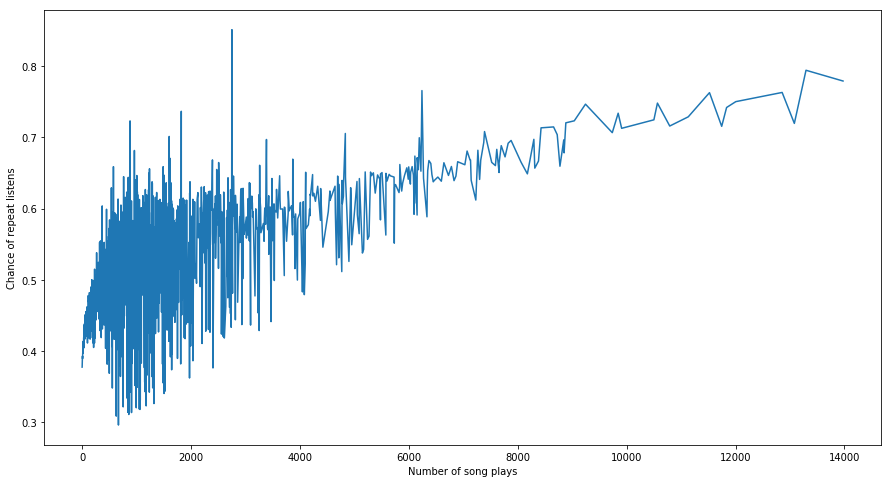

In [8]:
x_plays = []
y_repeat_chance = []

for i in range(1,song_data['plays'].max()+1):
    plays_i = song_data[song_data['plays']==i]
    count = plays_i['plays'].sum()
    if count > 0:
        x_plays.append(i)
        y_repeat_chance.append(plays_i['repeat_events'].sum() / count)

plt.figure(figsize=(15,8))      
plt.xlabel('Number of song plays')  #歌曲播放次数
plt.ylabel('Chance of repeat listens') #歌曲重复播放概率
plt.plot(x_plays, y_repeat_chance)



- 显而易见， 播放次数与歌曲重复播放概率相关性大。 其次 噪音也很大。

### 风格、lyr、composer

In [9]:
def count_vals(x):
    # count number of values (since we can have mutliple values separated by '|')
    if type(x) != str:
        return 1
    else:
        return 1 + x.count('|')
    
# 统计 genres, composers, lyricsts
song_data['number_of_genres'] = song_data['genre_ids'].apply(count_vals)
song_data['number_of_composers'] = song_data['composer'].apply(count_vals)
song_data['number_of_lyricists'] = song_data['lyricist'].apply(count_vals)

n_genres_max = song_data['number_of_genres'].max()
n_composers_max = song_data['number_of_composers'].max()
n_lyricists_max = song_data['number_of_lyricists'].max()

print(n_genres_max, n_composers_max, n_lyricists_max)

8 51 23


- composers 和 lyricists 明显反常

In [10]:
max_comp_song = song_data.iloc[song_data['number_of_composers'].idxmax()]
max_lyr_song = song_data.iloc[song_data['number_of_lyricists'].idxmax()]

print(max_comp_song[['artist_name', 'composer', 'lyricist', 'number_of_composers',
                     'number_of_lyricists']], '\n')
print(max_lyr_song[['artist_name', 'composer', 'lyricist', 'number_of_composers',
                    'number_of_lyricists']])

artist_name                                                       SHINee
composer               Korean Lyrics by Kim| Jong Hyun (12.5%) Harvey...
lyricist                          Andreas "Quiz" Romdhane| Savan Kotecha
number_of_composers                                                   51
number_of_lyricists                                                    2
Name: 309485, dtype: object 

artist_name                                                       Coolio
composer               A. Ivey| A. Jones| Bar-keys| C. Allen| C. Fran...
lyricist               A. Ivey| A. Jones| Bar-keys| C. Allen| C. Fran...
number_of_composers                                                   23
number_of_lyricists                                                   23
Name: 106071, dtype: object


In [11]:
x_genres = list(range(1,n_genres_max+1))
x_composers = list(range(1,n_composers_max+1))
x_lyricists = list(range(1,n_lyricists_max+1))

y_genres = [song_data[song_data['number_of_genres'] == x].shape[0] for x in x_genres]
y_composers = [song_data[song_data['number_of_composers'] == x].shape[0] for x in x_composers]
y_lyricists = [song_data[song_data['number_of_lyricists'] == x].shape[0] for x in x_lyricists]

In [ ]:
# 处理0值 和 NA
empty_ids = [i for i, y in enumerate(y_composers) if y == 0]
x_composers_fixed = [x_composers[i] for i in range(0,n_composers_max) if i not in empty_ids]
y_composers_fixed = [y_composers[i-1] for i in x_composers_fixed]

empty_ids = [i for i, y in enumerate(y_lyricists) if y == 0]
x_lyricists_fixed = [x_lyricists[i] for i in range(0,n_lyricists_max) if i not in empty_ids]
y_lyricists_fixed = [y_lyricists[i-1] for i in x_lyricists_fixed]


y_repeat_chance_g = []
y_plays_g = []

for i in range(1,n_genres_max+1):
    genres_i = song_data[song_data['number_of_genres']==i]
    count = genres_i['plays'].sum()
    y_repeat_chance_g.append(genres_i['repeat_events'].sum() / count)
    y_plays_g.append(count)
    
y_repeat_chance_c = []
y_plays_c = []

for i in x_composers_fixed:
    composers_i = song_data[song_data['number_of_composers']==i]
    count = composers_i['plays'].sum()
    y_repeat_chance_c.append(composers_i['repeat_events'].sum() / count)
    y_plays_c.append(count)
    
y_repeat_chance_l = []
y_plays_l = []

for i in x_lyricists_fixed:
    lyricists_i = song_data[song_data['number_of_lyricists']==i]
    count = lyricists_i['plays'].sum()
    y_repeat_chance_l.append(lyricists_i['repeat_events'].sum() / count)
    y_plays_l.append(count)

In [ ]:
fig = plt.figure(figsize=(15, 18)) 

ax331 = plt.subplot(3,3,1)
sns.barplot(x=x_genres,y=np.log10(y_genres))
ax331.set_ylabel('log10(# of songs)')
ax334 = plt.subplot(3,3,4)
sns.barplot(x=x_genres,y=np.log10(y_plays_g))
ax334.set_ylabel('log10(# of plays)')
ax337 = plt.subplot(3,3,7)
sns.barplot(x=x_genres,y=y_repeat_chance_g)
ax337.set_xlabel('# of genres')
ax337.set_ylabel('chance of repeated listen')

plt.subplot(3,3,2)
sns.barplot(x=x_composers_fixed,y=np.log10(y_composers_fixed))
plt.subplot(3,3,5)
sns.barplot(x=x_composers_fixed,y=np.log10(y_plays_c))
ax338 = plt.subplot(3,3,8)
sns.barplot(x=x_composers_fixed,y=y_repeat_chance_c)
ax338.set_xlabel('# of composers')


plt.subplot(3,3,3)
sns.barplot(x=x_lyricists_fixed,y=np.log10(y_lyricists_fixed))
plt.subplot(3,3,6)
sns.barplot(x=x_lyricists_fixed,y=np.log10(y_plays_l))
ax339 = plt.subplot(3,3,9)
sns.barplot(x=x_lyricists_fixed,y=y_repeat_chance_l)
ax339.set_xlabel('# of lyricists')

- Composer 和 lyricists 的数量 无影响。 而Genres的数量有一些相关性

### 语言

In [ ]:
languages = song_data['language'].unique()
print(languages.shape[0])

language_count = []
language_plays = []
language_repeat_chance = []

for l in languages:
    if not np.isnan(l):
        songs_with_language = song_data[song_data['language']==l]
        count = songs_with_language['plays'].sum()
        language_repeat_chance.append(songs_with_language['repeat_events'].sum() / count)
        language_count.append(songs_with_language.shape[0])
        language_plays.append(count)
    else:
        songs_with_language = song_data[pd.isnull(song_data['language'])]
        count = songs_with_language['plays'].sum()
        language_repeat_chance.append(songs_with_language['repeat_events'].sum() / count)
        language_count.append(songs_with_language.shape[0])
        language_plays.append(count)
        
languages[10] = -100  # 填充NA值

In [ ]:
fig = plt.figure(figsize=(15, 18)) 

ax1 = plt.subplot(3,1,1)
sns.barplot(x=languages,y=np.log10(language_count))
ax1.set_ylabel('log10(# of songs)')
ax2 = plt.subplot(3,1,2)
sns.barplot(x=languages,y=np.log10(language_plays))
ax2.set_ylabel('log10(# of plays)')
ax3 = plt.subplot(3,1,3)
sns.barplot(x=languages,y=language_repeat_chance)
ax3.set_ylabel('Chance of repeated listen')
ax3.set_xlabel('Song language')

-1 17 45 语言重复率更低

## 歌曲时间

In [ ]:
min_song_length_sec = song_data['song_length'].min() / 1000  
max_song_length_sec = song_data['song_length'].max() / 1000
print(min_song_length_sec, max_song_length_sec)

1秒歌 和 三小时歌=，=

In [ ]:
min_length_song = song_data.iloc[song_data['song_length'].idxmin()]
max_length_song = song_data.iloc[song_data['song_length'].idxmax()]

print(min_length_song[['artist_name', 'composer', 'lyricist', 'number_of_composers',
                       'number_of_lyricists', 'song_length', 'repeat_play_chance']], '\n')
print(max_length_song[['artist_name', 'composer', 'lyricist', 'number_of_composers',
                       'number_of_lyricists', 'song_length', 'repeat_play_chance']])

In [ ]:
plt.figure(figsize=(15,8))
length_bins = np.logspace(np.log10(min_song_length_sec),np.log10(max_song_length_sec+1),100)
sns.distplot(song_data['song_length']/1000, bins=length_bins, kde=False,
             hist_kws={"alpha": 1})
plt.xlabel('song length, s')
plt.ylabel('# of songs')
plt.yscale('log')
plt.xscale('log')

In [ ]:
time_labels = list(range(length_bins.shape[0]-1))
song_data['time_cuts'] = pd.cut(song_data['song_length']/1000,
                                bins=length_bins, labels=time_labels)

y_repeat_chance_tc = []
y_plays_tc = []
y_rel_plays = []
for i in time_labels:
    timecut_i = song_data[song_data['time_cuts']==i]
    count = timecut_i['plays'].sum()
    y_plays_tc.append(count)
    if count != 0:
        y_repeat_chance_tc.append(timecut_i['repeat_events'].sum() / count)
        y_rel_plays.append(count / timecut_i.shape[0])
    else:
        y_repeat_chance_tc.append(0)
        y_rel_plays.append(0)
    
fig = plt.figure(figsize=(15, 16)) 

y_plays_tc = [yptc + 1 for yptc in y_plays_tc]  # otherwise we'll get errors when we take the log

ax211 = plt.subplot(2,1,1)
sns.barplot(x=length_bins[time_labels],y=np.log10(y_plays_tc))
ax211.set_ylabel('log10(# of plays)')

ax212 = plt.subplot(2,1,2)
sns.barplot(x=length_bins[time_labels],y=y_repeat_chance_tc)
ax212.set_ylabel('Chance of repeated listen')

## 歌手分析

In [ ]:
artist_replgroupby = song_data[['artist_name', 'plays', 'repeat_events']].groupby(['artist_name'])
artist_replgroupby = artist_replgroupby['plays', 'repeat_events'].agg(['sum', 'count'])
artist_replgroupby.reset_index(inplace=True)
artist_replgroupby.columns = list(map(''.join, artist_replgroupby.columns.values))
artist_replgroupby.drop(['repeat_eventscount'], axis=1, inplace=True)
artist_replgroupby.columns = ['artist', 'plays', 'tracks', 'repeat_events']
artist_replgroupby['repeat_play_chance'] = artist_replgroupby['repeat_events'] / artist_replgroupby['plays']

play_bins = np.logspace(-0.01, np.log10(artist_replgroupby['plays'].max()), 100)
play_labels = list(range(play_bins.shape[0]-1))
artist_replgroupby['play_cuts'] = pd.cut(artist_replgroupby['plays'],
                                         bins=play_bins, labels=play_labels)

y_repeat_chance_p = []
y_plays_p = []
for i in play_labels:
    playcut_i = artist_replgroupby[artist_replgroupby['play_cuts']==i]
    count = artist_replgroupby['plays'].sum()
    y_plays_p.append(count)
    if count != 0:
        y_repeat_chance_p.append(playcut_i['repeat_events'].sum() / count)
    else:
        y_repeat_chance_p.append(0)
    
fig = plt.figure(figsize=(15, 16)) 

ax111 = plt.subplot(1,1,1)
sns.barplot(x=play_bins[play_labels],y=y_repeat_chance_p)
ax111.set_xlabel('log10(# of plays)')
ax111.set_ylabel('Chance of repeated listen')

In [ ]:
plt.figure(figsize=(15,8))
chance_bins = np.linspace(0,1,100)
sns.distplot(artist_replgroupby['repeat_play_chance'], bins=chance_bins, kde=False,
             hist_kws={"alpha": 1})
plt.xlabel('Chance of repeated listens')
plt.ylabel('# of artists')
plt.yscale('log')
# plt.xscale('log')

播放次数越多的，其重复播放的概率更大

## 总结

以下特征可能有效：
- 1. 歌曲风格数量
- 2. composer 和 lyricsts 数量
- 3. 歌曲被播放数量
- 4. 歌手歌曲被播放总量
- 5. 歌曲长度